In [38]:
# Standard Imports
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import re

# Additional imports for training, clustering, visualization, and causal discovery
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# For causal discovery (if installed)
from causallearn.search.ConstraintBased.PC import pc
import networkx as nx


# ---------------------------
# Dataset Definitions

class LungCancerDataset(Dataset):
    def __init__(self, image_dir, transform=None, metric_learning=False):
        super().__init__()
        self.image_dir = image_dir
        self.transform = transform
        self.metric_learning = metric_learning

        # Map folder names to labels (expects folders: benign, malignant, normal)
        self.class_map = {
            folder_name: idx
            for idx, folder_name in enumerate(os.listdir(image_dir))
            if os.path.isdir(os.path.join(image_dir, folder_name))
        }

        self.image_paths = []
        self.labels = []
        self.class_to_images = {lbl: [] for lbl in self.class_map.values()}

        for class_name, label in self.class_map.items():
            class_dir = os.path.join(image_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(class_dir, file_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
                    self.class_to_images[label].append(img_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        if not self.metric_learning:
            # Standard classification
            return image, label
        else:
            # Triplet for metric learning
            anchor_image = image
            anchor_label = label

            # Positive: same class
            positive_image_path = random.choice(self.class_to_images[anchor_label])
            positive_image = Image.open(positive_image_path).convert("RGB")
            if self.transform:
                positive_image = self.transform(positive_image)

            # Negative: different class
            negative_label = random.choice([
                l for l in self.class_to_images.keys()
                if l != anchor_label
            ])
            negative_image_path = random.choice(self.class_to_images[negative_label])
            negative_image = Image.open(negative_image_path).convert("RGB")
            if self.transform:
                negative_image = self.transform(negative_image)

            return anchor_image, positive_image, negative_image

def get_image_dataloader(image_dir, batch_size=32, shuffle=True, metric_learning=False):
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = LungCancerDataset(
        image_dir=image_dir,
        transform=image_transform,
        metric_learning=metric_learning
    )
    dataloader = DataLoader(
        dataset, batch_size=batch_size,
        shuffle=shuffle, num_workers=0
    )
    return dataloader, dataset

class InsuranceDataset(Dataset):
    def __init__(self, csv_path, classification=True, transform=None):
        super().__init__()
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"CSV not found: {csv_path}")

        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.classification = classification

        # Convert text columns => numeric
        self.data["sex"] = self.data["sex"].map({"female": 0, "male": 1})
        self.data["smoker"] = self.data["smoker"].map({"no": 0, "yes": 1})
        region_map = {"southwest": 0, "southeast": 1, "northwest": 2, "northeast": 3}
        self.data["region"] = self.data["region"].map(region_map)

        if self.classification:
            # Bin 'charges' into 3 classes (e.g., low, mid, high)
            self.data["target"] = pd.cut(
                self.data["charges"],
                bins=[0, 10000, 20000, float("inf")],
                labels=[0, 1, 2]
            )
            self.data.dropna(subset=["target"], inplace=True)
            self.data["target"] = self.data["target"].astype(int)
        else:
            self.data["target"] = self.data["charges"].astype(float)

        self.feature_cols = ["age", "sex", "bmi", "children", "smoker", "region"]
        self.X = self.data[self.feature_cols].values
        self.y = self.data["target"].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        if self.classification:
            y_tensor = torch.tensor(y, dtype=torch.long)
        else:
            y_tensor = torch.tensor(y, dtype=torch.float32)

        return X_tensor, y_tensor

def get_tabular_dataloader(csv_path, batch_size=32, shuffle=True, classification=True):
    dataset = InsuranceDataset(
        csv_path=csv_path,
        classification=classification,
        transform=None
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0
    )
    return dataloader, dataset

# ---------------------------
# Model Definitions

class SimpleCNN(nn.Module):
    """
    CNN for lung cancer image classification.
    """
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.activations = {}

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        flattened_size = 128 * 28 * 28  # for input size 224x224

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Register forward hooks for latent space analysis
        self.conv1.register_forward_hook(self.save_activation('conv1'))
        self.conv2.register_forward_hook(self.save_activation('conv2'))
        self.conv3.register_forward_hook(self.save_activation('conv3'))
        self.fc1.register_forward_hook(self.save_activation('fc1'))

    def save_activation(self, name):
        def hook(module, input, output):
            self.activations[name] = output.detach()
        return hook

    def forward(self, x, return_embedding=False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        embedding = F.relu(self.fc2(x))
        logits = self.fc3(embedding)
        return embedding if return_embedding else logits

class SimpleMLP(nn.Module):
    """
    MLP for tabular data (Insurance).
    """
    def __init__(self, input_dim=6, hidden_dim=64, output_dim=3):
        super(SimpleMLP, self).__init__()
        self.activations = {}

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Register forward hooks for latent space analysis
        self.fc1.register_forward_hook(self.save_activation('fc1'))
        self.fc2.register_forward_hook(self.save_activation('fc2'))
        self.fc3.register_forward_hook(self.save_activation('fc3'))

    def save_activation(self, name):
        def hook(module, input, output):
            self.activations[name] = output.detach()
        return hook

    def forward(self, x, return_embedding=False):
        x = F.relu(self.fc1(x))
        embedding = F.relu(self.fc2(x))
        logits = self.fc3(embedding)
        return embedding if return_embedding else logits

# ---------------------------
# Training, Clustering & Visualization Helper Functions

def train_network(network, dataloader, device, num_epochs=5, lr=1e-3, use_metric_learning=False):
    criterion = nn.CrossEntropyLoss()
    metric_criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = optim.Adam(network.parameters(), lr=lr)

    for epoch in range(num_epochs):
        network.train()
        running_loss = 0.0

        for batch in dataloader:
            if use_metric_learning:
                anchor, positive, negative = batch
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
                optimizer.zero_grad()
                anchor_out = network(anchor, return_embedding=True)
                positive_out = network(positive, return_embedding=True)
                negative_out = network(negative, return_embedding=True)
                loss = metric_criterion(anchor_out, positive_out, negative_out)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = network(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    print("Training completed.")

def extract_activations(model, dataloader, device, metric_learning=False):
    model.eval()
    # Clear previous activations
    for layer in model.activations.keys():
        model.activations[layer] = None

    layer_outputs = {layer: [] for layer in model.activations.keys()}
    label_list = []

    with torch.no_grad():
        for batch in dataloader:
            if metric_learning:
                anchor, _, _ = batch
                anchor = anchor.to(device)
                _ = model(anchor)
                label_list.extend([0] * anchor.size(0))
            else:
                inputs, labels = batch
                inputs = inputs.to(device)
                _ = model(inputs)
                label_list.extend(labels.cpu().numpy())

            for layer_name, act_tensor in model.activations.items():
                if act_tensor is None:
                    continue
                if act_tensor.dim() == 4:
                    pooled = F.adaptive_avg_pool2d(act_tensor, (1, 1))
                    pooled = pooled.view(pooled.size(0), -1)
                    layer_outputs[layer_name].append(pooled.cpu().numpy())
                else:
                    layer_outputs[layer_name].append(act_tensor.cpu().numpy())

    for layer_name in layer_outputs.keys():
        if len(layer_outputs[layer_name]) > 0:
            layer_outputs[layer_name] = np.concatenate(layer_outputs[layer_name], axis=0)
        else:
            layer_outputs[layer_name] = np.array([])

    return layer_outputs, np.array(label_list)

def perform_clustering_optimized(activations, max_clusters=10, pca_components=50):
    clustering_results = {}
    for layer, act_data in activations.items():
        scaler = StandardScaler()
        normalized = scaler.fit_transform(act_data)
        if normalized.shape[1] > pca_components:
            pca = PCA(n_components=pca_components, random_state=42)
            reduced = pca.fit_transform(normalized)
        else:
            reduced = normalized

        best_n = 2
        best_score = -1
        for k in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            clusters = kmeans.fit_predict(reduced)
            score = silhouette_score(reduced, clusters)
            if score > best_score:
                best_score = score
                best_n = k
        print(f"{layer}: best_n={best_n}, silhouette={best_score:.4f}")
        final_kmeans = KMeans(n_clusters=best_n, random_state=42)
        clustering_results[layer] = final_kmeans.fit_predict(reduced)
    return clustering_results

def create_latent_cluster_dataset(clustering_results, labels):
    data_dict = {}
    for layer, clusters in clustering_results.items():
        data_dict[f"{layer}_cluster"] = clusters
    data_dict["label"] = labels
    return pd.DataFrame(data_dict)


def get_nodes_from_edge(edge):
    # If the edge is a string, use our previous logic.
    if isinstance(edge, str):
        edge_clean = edge.replace('-->', '->').replace('---', '->')
        parts = edge_clean.split('->')
        if len(parts) == 2:
            return parts[0].strip(), parts[1].strip()
        else:
            raise ValueError("Edge string not in expected format: " + edge)
    # Otherwise, if the edge has node1 and node2 attributes, use them.
    elif hasattr(edge, 'node1') and hasattr(edge, 'node2'):
        # Debug: print the node objects.
        print("DEBUG: Using node1 and node2 attributes:", edge.node1, edge.node2)
        # If the GraphNode has a 'name' attribute, return that; otherwise, use str().
        source = edge.node1.name if hasattr(edge.node1, 'name') else str(edge.node1)
        target = edge.node2.name if hasattr(edge.node2, 'name') else str(edge.node2)
        return source, target
    else:
        raise ValueError("Edge object is not recognized: " + str(edge))

def visualize_causal_graph(causal_graph, title="Causal Graph"):
    import networkx as nx
    import matplotlib.pyplot as plt

    if causal_graph is None:
        print("No causal graph to visualize.")
        return

    G = nx.DiGraph()
    edges = causal_graph.get_graph_edges()
    for edge in edges:
        try:
            source, target = get_nodes_from_edge(edge)
        except Exception as e:
            print("DEBUG: Cannot extract nodes from edge:", edge, "Error:", e)
            continue
        G.add_edge(str(source), str(target))
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_size=500, node_color="lightblue", arrows=True)
    plt.title(title)
    plt.show()



def causal_discovery_all_layers(cluster_df, layer_names):
    causal_graphs = {}
    try:
        data_np = cluster_df.drop(columns=["label"]).to_numpy()
        pc_result = pc(data_np)
        causal_graphs["all_layers"] = pc_result.G
        visualize_causal_graph(pc_result.G, title="All Layers Causal Graph")
    except Exception as e:
        print(f"Error in causal discovery: {e}")
    return causal_graphs

def visualize_clusters(activations, clustering_results, layer_name, apply_pca=True,
                       pca_components=50, tsne_perplexity=30, tsne_n_iter=1000):
    data = activations[layer_name]
    if apply_pca and data.shape[1] > pca_components:
        pca = PCA(n_components=pca_components, random_state=42)
        data = pca.fit_transform(data)
    tsne = TSNE(n_components=2, perplexity=tsne_perplexity, n_iter=tsne_n_iter, random_state=42)
    emb_2d = tsne.fit_transform(data)
    cluster_assign = clustering_results[layer_name]
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=cluster_assign, cmap="tab10", s=5)
    plt.title(f"{layer_name} Clusters (t-SNE)")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()


In [22]:
# Set up device and configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up your image dataset (expects folders 'benign', 'malignant', 'normal')
image_dir = "Data/Image/IQ-OTHNCCD"
dataloader, dataset = get_image_dataloader(
    image_dir=image_dir,
    batch_size=16,
    shuffle=True,
    metric_learning=True  # For triplet training; set False for standard classification
)
num_classes = len(dataset.class_map)
print("Class Map:", dataset.class_map)

# Initialize and train the SimpleCNN model
model = SimpleCNN(num_classes=num_classes).to(device)
train_network(model, dataloader, device, num_epochs=5, lr=1e-3, use_metric_learning=True)

# Save the trained model
torch.save(model.state_dict(), "lung_cancer_model.pth")
print("Model saved as lung_cancer_model.pth")


Using device: cpu
Class Map: {'Bengin cases': 0, 'Normal cases': 1, 'Malignant cases': 2}
Epoch [1/5], Loss: 0.6276
Epoch [2/5], Loss: 0.2319
Epoch [3/5], Loss: 0.1302
Epoch [4/5], Loss: 0.0867
Epoch [5/5], Loss: 0.0521
Training completed.
Model saved as lung_cancer_model.pth


In [37]:
# (Optional) Load the saved model if needed
if not model:
    model = SimpleCNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load("lung_cancer_model.pth", map_location=device))
    model.eval()
    print("Loaded model from lung_cancer_model.pth")

# Extract activations from the trained model
acts, labels = extract_activations(model, dataloader, device, metric_learning=True)

# Perform clustering with PCA preprocessing
clustering_res = perform_clustering_optimized(acts, max_clusters=10, pca_components=50)
cluster_df = create_latent_cluster_dataset(clustering_res, labels)
print("Cluster assignments (first 5 samples):")
print(cluster_df.head())

# Run causal discovery on the clusters
causal_graphs = causal_discovery_all_layers(cluster_df, layer_names=model.activations.keys())

# Visualize clusters for each hooked layer
for layer in model.activations.keys():
    visualize_clusters(acts, clustering_res, layer,
                       apply_pca=True, pca_components=50,
                       tsne_perplexity=30, tsne_n_iter=1000)


conv1: best_n=3, silhouette=0.6045
conv2: best_n=5, silhouette=0.4082
conv3: best_n=2, silhouette=0.3921
fc1: best_n=3, silhouette=0.2605
Cluster assignments (first 5 samples):
   conv1_cluster  conv2_cluster  conv3_cluster  fc1_cluster  label
0              0              4              1            1      0
1              1              4              0            2      0
2              2              3              0            2      0
3              1              4              0            0      0
4              1              4              1            2      0


Depth=2, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 2044.01it/s]

DEBUG: Processing edge: X2 --> X1 Type: <class 'causallearn.graph.Edge.Edge'>
DEBUG: Edge __dict__: {'properties': [], 'node1': <causallearn.graph.GraphNode.GraphNode object at 0x32a474400>, 'node2': <causallearn.graph.GraphNode.GraphNode object at 0x32a474b50>, 'endpoint1': <Endpoint.TAIL: -1>, 'endpoint2': <Endpoint.ARROW: 1>, 'numerical_endpoint_1': -1, 'numerical_endpoint_2': 1}
DEBUG: Attempting to extract using attributes 'from_node' and 'to_node'.
DEBUG: Failed attribute extraction: 'Edge' object has no attribute 'from_node'
DEBUG: Attempting to extract using indexing.
DEBUG: Failed indexing extraction: 'Edge' object is not subscriptable
DEBUG: Cannot extract nodes from edge: X2 --> X1 Error: Cannot extract nodes from edge object: X2 --> X1
DEBUG: Processing edge: X4 --> X1 Type: <class 'causallearn.graph.Edge.Edge'>
DEBUG: Edge __dict__: {'properties': [], 'node1': <causallearn.graph.GraphNode.GraphNode object at 0x32a474190>, 'node2': <causallearn.graph.GraphNode.GraphNode obj

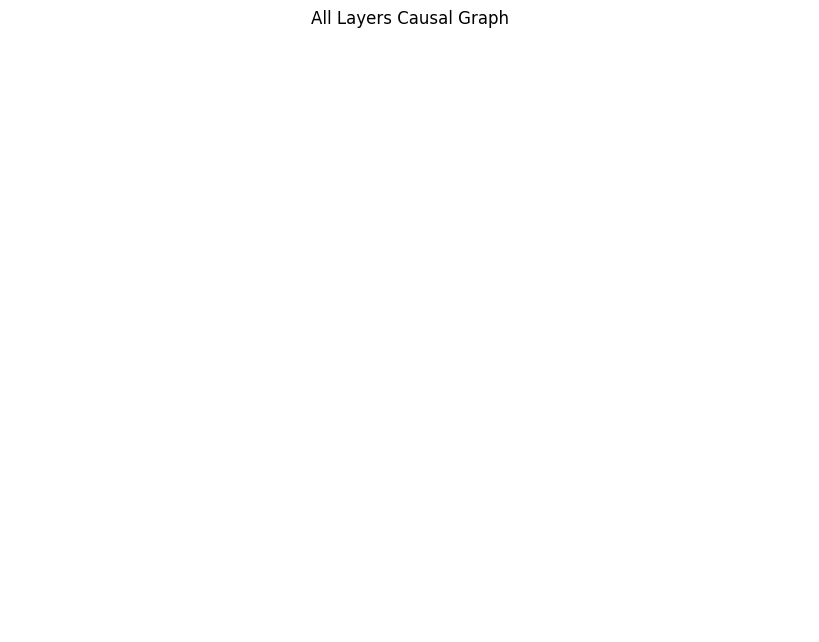

/Users/kristianoconnor/Documents/Creations/CausalClusters/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


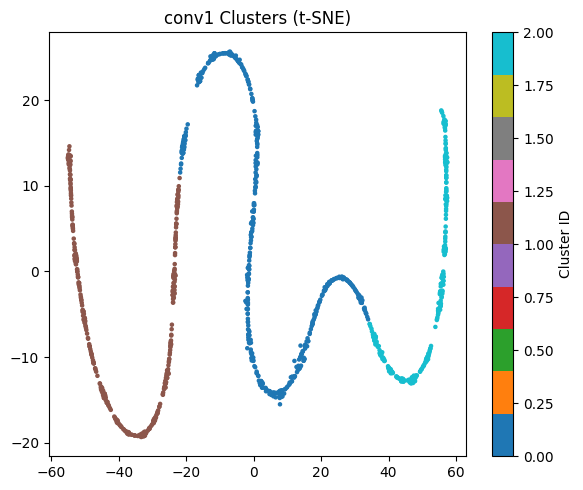

/Users/kristianoconnor/Documents/Creations/CausalClusters/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


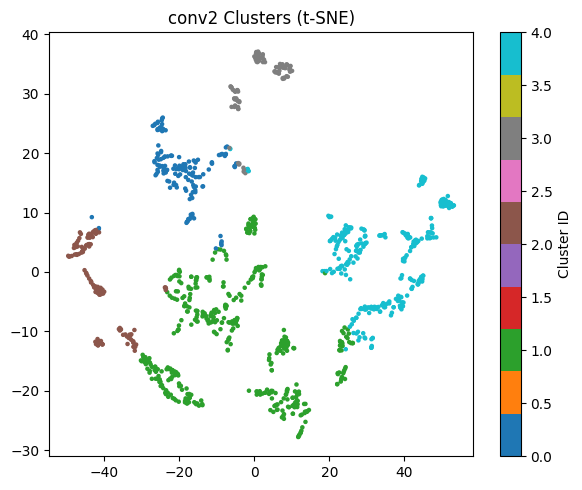

/Users/kristianoconnor/Documents/Creations/CausalClusters/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


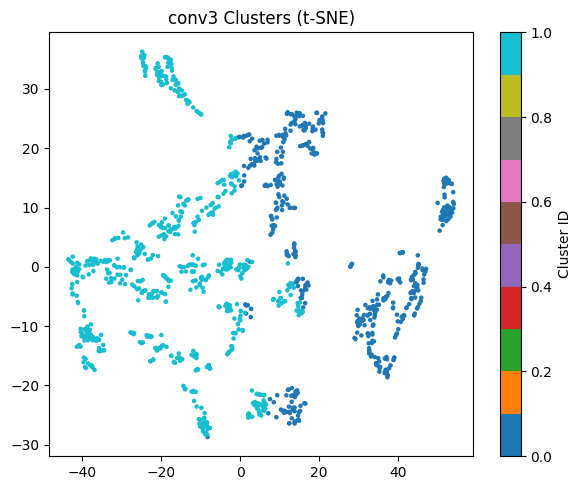

/Users/kristianoconnor/Documents/Creations/CausalClusters/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


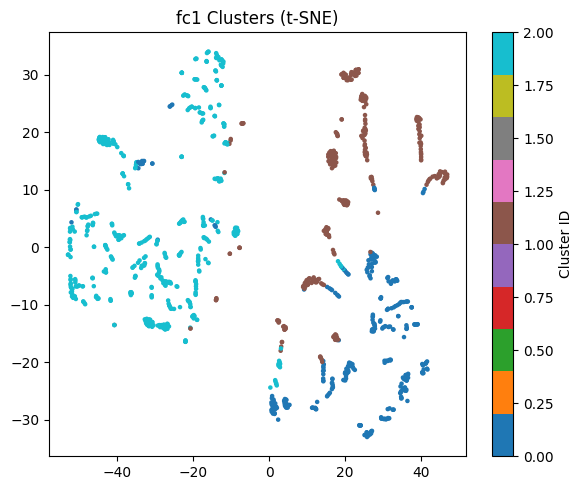

In [39]:
# (Optional) Load the saved model if needed
if not model:
    model = SimpleCNN(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load("lung_cancer_model.pth", map_location=device))
    model.eval()
    print("Loaded model from lung_cancer_model.pth")

# Extract activations from the trained model
acts, labels = extract_activations(model, dataloader, device, metric_learning=True)

# Perform clustering with PCA preprocessing
clustering_res = perform_clustering_optimized(acts, max_clusters=10, pca_components=50)
cluster_df = create_latent_cluster_dataset(clustering_res, labels)
print("Cluster assignments (first 5 samples):")
print(cluster_df.head())

# Run causal discovery on the clusters
causal_graphs = causal_discovery_all_layers(cluster_df, layer_names=model.activations.keys())

# Visualize clusters for each hooked layer
for layer in model.activations.keys():
    visualize_clusters(acts, clustering_res, layer,
                       apply_pca=True, pca_components=50,
                       tsne_perplexity=30, tsne_n_iter=1000)


In [4]:
# Set up the tabular dataset
csv_path = "Data/Tabular/insurance.csv"
dl, ds = get_tabular_dataloader(csv_path, batch_size=32, shuffle=True, classification=True)

# Initialize and train the SimpleMLP model (for 3 classes, e.g., low, mid, high)
model_tab = SimpleMLP(input_dim=6, hidden_dim=64, output_dim=3).to(device)
train_network(model_tab, dl, device, num_epochs=5, lr=1e-3, use_metric_learning=True)

# Extract activations (SimpleMLP should have forward hooks enabled)
acts_tab, labels_tab = extract_activations(model_tab, dl, device, metric_learning=True)

# Perform clustering on the tabular activations
clustering_res_tab = perform_clustering_optimized(acts_tab, max_clusters=10, pca_components=50)
cluster_df_tab = create_latent_cluster_dataset(clustering_res_tab, labels_tab)
print("Tabular cluster assignments (first 5 samples):")
print(cluster_df_tab.head())

# Run causal discovery on tabular clusters
c_graphs = causal_discovery_all_layers(cluster_df_tab, layer_names=model_tab.activations.keys())

# Visualize clusters for each layer in the tabular model
for layer in model_tab.activations.keys():
    visualize_clusters(acts_tab, clustering_res_tab, layer,
                       apply_pca=True, pca_components=50,
                       tsne_perplexity=30, tsne_n_iter=1000)
